# Mantenimiento Predictivo Basado en Datos de Equipamiento de Microsoft Azure
~~~
Grupo 4

Brami Prudencio, Ricardo Fernández y Pablo Rivas
~~~
## Resumen

El objetivo es construir un modelo de ML para predecir cuando habrá un fallo en los equipos, apoyandose en datos de telemetria y reportes de fallos, errores y mantenimientos. Pero para predecir los posibles fallos, uno debe saber que falla, cuanto tiempo resiste, que valores son los influyentes y más. Por tanto, para analizar el comportamiento tanto de los equipos como del modelo generado y comprender la situación, se requiere conocer el proposito de las distintas variables y la relacion que tienen.

## Contexto

El mantenimiento predictivo es 
una solución que utiliza tecnicas de data analysis y tecnicas de detección de anomalias para mantener operativo el equipamiento que se puede reparar antes de que resulten en fallos.

Se escogio este tema por que idealmente se espera resolver problemas serios y dificiles como estos, manteniendo una manera efectiva de realizar mantenimiento reactivo sin incurrir a costos posteriores al desarrollo.

<img src="img/predictive-maintenance.jpg" width="800">

---
## Los datos 

Los datos estan en el folder "data", en este directorio encontraran 5 archivos:


### `PdM_errors.csv`

Es un archivo csv que contiene el registro de los errores que no rompen su funcionamiento y permiten al sistema seguir siendo funcional, asi que no se nombran como fallos.

**Ejemplo:**
~~~
     datetime            machineID    errorID
2015-01-03 07:00:00         1          error1
2015-01-03 20:00:00         1          error3
2015-01-04 06:00:00         1          error5
(...)
~~~

### `PdM_failures.csv`

Es un archivo csv que contiene el registro de los componentes que se tienen que reemplazar debido a fallos donde se guarda la fecha en que se arruino, la maquina que fue y el tipo de componente que fallo., 

**Ejemplo:**
~~~
     datetime            machineID    failure
2015-01-05 06:00:00         1          comp4
2015-03-06 06:00:00         1          comp1
2015-04-20 06:00:00         1          comp2
(...)
~~~

### `PdM_machines.csv`

Es un archivo csv que incluye la meta data sobre las maquinas, ya que involucra el modelo que es el equipo y la cantidad de años en servicio que tiene.


~~~
machineID    model       age
    1        model3      18
    2        model4       7
    3        model3       8
(...)
~~~

### `PdM_maint.csv`
Es un archivo csv que contiene los registros de mantenimientos programados y no programados para la inspección de componentes, asi como sus fallos. Estos normalmente se generan si se reemplaza un componente debido a esa inspección o debido a un colapso del sistema. Estos son los registros del 2014 y 2015.

**Ejemplo:**
~~~
     datetime            machineID    comp
2014-06-01 06:00:00         1         comp2
2014-07-16 06:00:00         1         comp4
2014-07-31 06:00:00         1         comp3
(...)
~~~

### `PdM_telemetry.csv`

Es un archivo csv que contiene la información de telemetria de los equipos, que consiste de datos medibles colectados de 100 maquinas en tiempo real, donde esas medidas se promedian cada hora durante el año 2015. 

**Ejemplo:**
~~~
     datetime       machineID         volt            rotate          pressure         vibration
2015-01-01 06:00:00    1       176.217853015625 418.504078221616 113.077935462083  45.0876857639276
2015-01-01 07:00:00    1       162.87922289706  402.747489565395 95.4605253823187  43.4139726834815
2015-01-01 08:00:00    1       170.989902405567 527.349825452291 75.2379048586662  34.1788471214451
(...)
~~~

**This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance, current versions are no longer available.**

---

## Paso 1:_ Cargar los datos

---

Lo primero que se hace es cargar las librerias que se emplearan, asi como cargar los archivos que se emplearan y crear métodos que usaremos a futuro, pero no necesitamos conocer directamente a profundidad:

In [1]:
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats

from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, mean_squared_error, r2_score, coverage_error, label_ranking_average_precision_score, label_ranking_loss

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain, MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.linear_model import SGDRegressor, SGDClassifier, RidgeClassifier, Ridge, Lars, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
def plotMachineRecords(telemetry_records):
    plt.figure(figsize=(25,4))
    for telemetry_feature in telemetry_features:
        plt.plot(telemetry_records.index, telemetry_records[telemetry_feature])
def plotErrorsAndFailures():
    fails = failures.groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    fails = fails[fails['machineID'].notna()]
    groupederrors = errors.groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    groupederrors = groupederrors[groupederrors['machineID'].notna()]
    for date in fails.index:
        plt.axvline(date, color = 'black', label = 'axvline - full height', lw = 2)
    for date in groupederrors.index:
        plt.axvline(date, color = 'purple', label = 'axvline - full height', linestyle = '--')
    plt.legend(telemetry_features + ['Errors', 'Failures'], loc = 'upper right')
    plt.xlabel('Time')
    plt.ylabel('Value of Telemetry Data')
    plt.title('Telemetry, Errors and Failures through Time For All Machines Grouped By 2 Days')
def plotMachineRecordsForSegments(m_list, telemetry_records):
    segmented_fails = failures[failures.apply(lambda x: x['machineID'] in m_list, axis=1)].groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    segmented_fails = segmented_fails[segmented_fails['machineID'].notna()]
    segmented_groupederrors = errors[errors.apply(lambda x: x['machineID'] in m_list, axis=1)].groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    segmented_groupederrors = segmented_groupederrors[segmented_groupederrors['machineID'].notna()]
    plt.figure(figsize=(20,4))
    for telemetry_feature in telemetry_features:
        plt.plot(telemetry_records.index, telemetry_records[telemetry_feature])
    for date in segmented_fails.index:
        plt.axvline(date, color = 'black', label = 'axvline - full height', lw = 2)
    for date in segmented_groupederrors.index:
        plt.axvline(date, color = 'purple', label = 'axvline - full height', linestyle = '--')
    plt.legend(telemetry_features + ['Errors', 'Failures'], loc = 'upper right')
    plt.xlabel('Time')
    plt.ylabel('Value of Telemetry Data')
    plt.title('Telemetry, Errors and Failures Of One Machine through Time Grouped By 2 Days')
def getModel(m):
    if m == 'model1':
        return 1
    elif m == 'model2':
        return 2
    elif m == 'model3':
        return 3
    else:
        return 4
def genHours(end_time, t):
    genhours = []
    for hours in range(t)[::-1]:
        genhours.append(end_time - pd.Timedelta(hours=hours))
    return genhours
def genFailPrev(failure, column_times):
    previous_failures = pd.DataFrame(np.repeat([failure.values], column_times, axis=0))
    previous_failures.columns = failure.index
    for fail in failure_labels:
        if previous_failures[fail][0] == 1:
            previous_failures[fail] = np.repeat(1, repeats=column_times)
            previous_failures['datetime'] = genHours(failure['datetime'], column_times) 
    return previous_failures
def genFailPrevScaloned(failure, column_times):
    previous_failures = pd.DataFrame(np.repeat([failure.values], column_times, axis=0))
    previous_failures.columns = failure.index
    for fail in failure_labels:
        if previous_failures[fail][0] == 1:
            previous_failures[fail] = np.linspace(0, 1, num=column_times, endpoint=False)
            previous_failures['datetime'] = genHours(failure['datetime'], column_times) 
    return previous_failures
def getClassifierScores(classifier, scores, feat, X_train, X_test, y_train, y_test):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    return scores.append(pd.DataFrame({
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }, index=[classifier.__class__.__name__ + '_' + feat]))

def getClassifierScoresType(scores, feat, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)
    for classifier in classifiers:
        scores = getClassifierScores(classifier, scores, feat, X_train, X_test, y_train, y_test)
    return scores

Posteriormente cargamos los datasets que emplearemos, asi como modificamos sus fechas que fueron guardadas como string

In [3]:
errors =  pd.read_csv('data/PdM_errors.csv')
errors['datetime'] = pd.to_datetime(errors['datetime'])

failures =  pd.read_csv('data/PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])

machines =  pd.read_csv('data/PdM_machines.csv')

maint =  pd.read_csv('data/PdM_maint.csv')
maint['datetime'] = pd.to_datetime(maint['datetime'])

telemetry =  pd.read_csv('data/PdM_telemetry.csv')
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
telemetry_features = ['volt', 'rotate', 'pressure', 'vibration']

#scaler = StandardScaler()
test_size = 0.2

---

## Paso 2: Estudiar los datos

---

#### Relación entre los modelos y la cantidad de componentes

---

Primero veremos la cantidad de los modelos que existen y cuantas veces se cambiaron los componentes que se cambiaron 

Text(0.5, 1.0, 'Components')

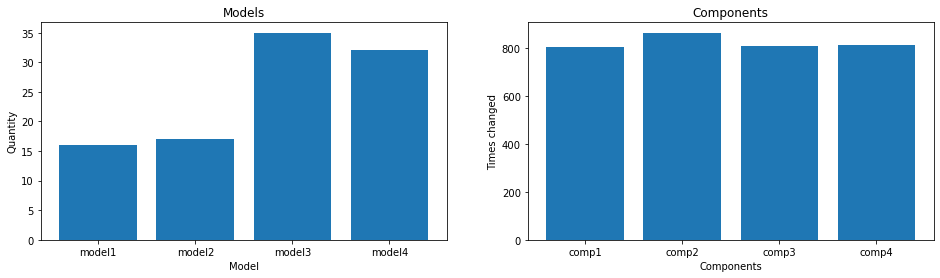

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
models = machines.groupby('model').size()
components = maint.groupby('comp').size()
axs[0].bar(models.index, models.values)
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Quantity')
axs[0].set_title('Models')
axs[1].bar(components.index, components.values)
axs[1].set_xlabel('Components')
axs[1].set_ylabel('Times changed')
axs[1].set_title('Components')

Se observa que **hay casi el doble de modelos 3 y 4 que los que hay del modelo 1 y 2 del total**, sin embargo, **la cantidad de veces que se cambiaron los componentes en total es similar**, asi que podemos empezar a hacer supocisiones para las preguntas que se realizaran sobre que equipos fallan más.

Posteriormente, vemos solo de los 10 equipos más antiguos y nuevos y notamos, que no hay mucha varianza en cuanto al panorama general, ya que practicamente **hay al menos el doble de modelos** 3 y 4 que los modelos 1 y 2. 

Text(0.5, 1.0, 'Youngest models')

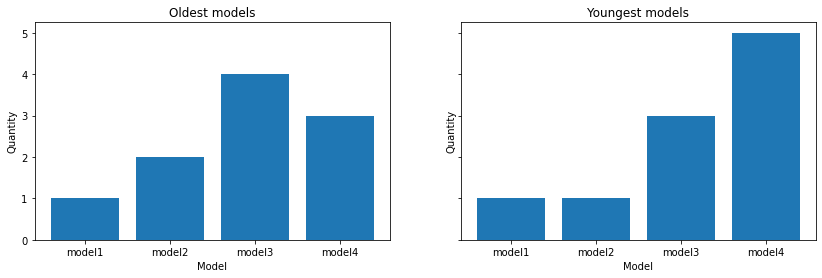

In [5]:
youngest_machine = machines[machines['age'] == np.min(machines['age'])].index[0]
oldest_machine = machines[machines['age'] == np.max(machines['age'])].index[1]

oldest_machines = machines.sort_values('age', ascending=False).iloc[:10]
youngest_machines = machines.sort_values('age').iloc[:10]

oldest_models = oldest_machines.groupby('model').size()
youngest_models = youngest_machines.groupby('model').size()

fig, axs = plt.subplots(1, 2, figsize=(14,4), sharey=True)
axs[0].bar(oldest_models.index, oldest_models.values)
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Quantity')
axs[0].set_title('Oldest models')
axs[1].bar(youngest_models.index, youngest_models.values)
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Quantity')
axs[1].set_title('Youngest models')

Ahora observaremos la **introducción de nuevos equipamientos separados según el modelo a lo largo de los años**, se puede observar que el modelo 1 y 2 son los que menos se van acumulando a traves del tiempo.

Text(0.5, 1.0, 'Models in use by years')

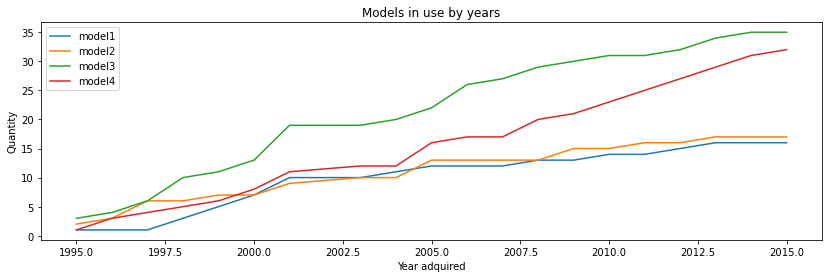

In [6]:
models_year = machines.groupby(['age', 'model'], as_index=False).count().pivot(index='age', columns='model', values='machineID')[::-1]
models_year.index = 2015 - models_year.index
models_year = models_year.fillna(0)
models_year = models_year.cumsum()

plt.figure(figsize=(14,4))
plt.plot(models_year.index, models_year)
plt.legend(models_year.columns)
plt.xlabel('Year adquired')
plt.ylabel('Quantity')
plt.title('Models in use by years')

#### Relación entre los valores de Telemetría

---

Tambien queremos saber sobre los **valores de telemetria que los equipos tienen**, para esto veremos en un plot como cambia el promedio de todos los equipos para el tiempo:

Text(0.5, 1.0, 'All Telemetry Values through Time')

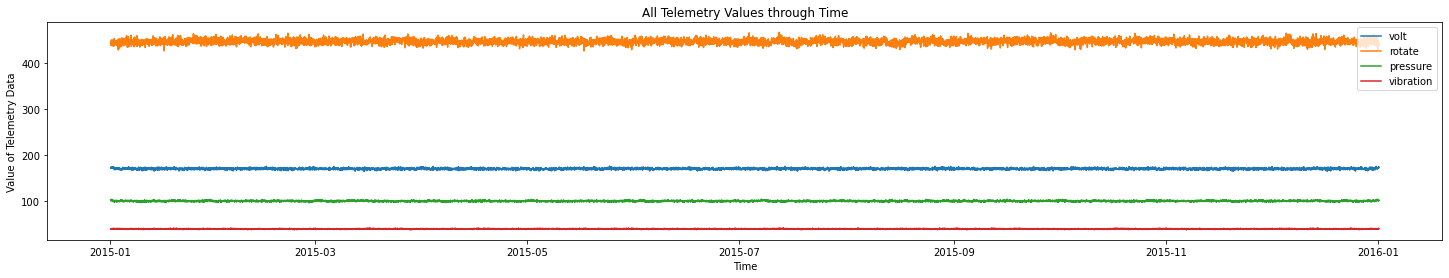

In [7]:
plotMachineRecords(telemetry.groupby('datetime').mean())
plt.legend(telemetry_features, loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Value of Telemetry Data')
plt.title('All Telemetry Values through Time')

Wow, es bastante **complicado apreciar los valores, ¿Verdad? Eso es por que las lecturas de los valores son cada hora**, para
aliviar la vista, a continuación demosle una **frecuencia de cada 2 días para observarlo mejor**.

Text(0.5, 1.0, 'All telemetry Values through Time Grouped By 2 Days')

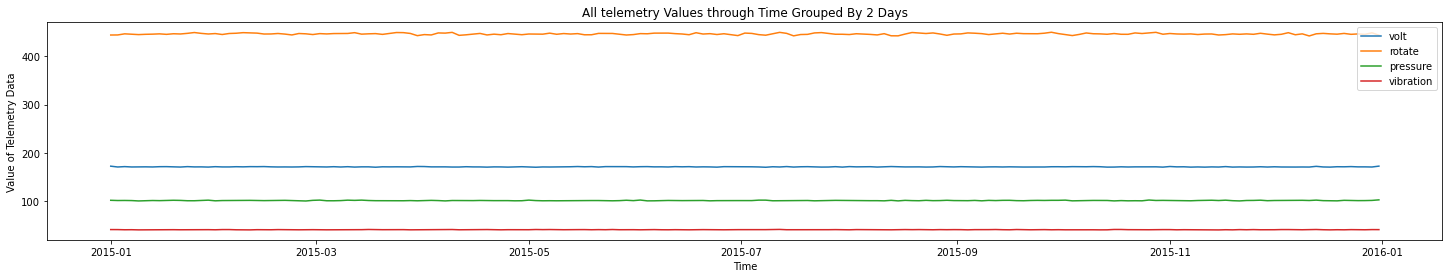

In [8]:
telemetry_values_total = telemetry.groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plotMachineRecords(telemetry_values_total)
plt.legend(telemetry_features, loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Value of Telemetry Data')
plt.title('All telemetry Values through Time Grouped By 2 Days')

Ahora los datos **parecen bastante planos**, tal vez sea por que es el promedio de todas las máquinas, **y si  solo usamos una muestra del 10% de las máquinas al azar**.

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 1.0, 'Telemetry Values through Time of a 10% sample of Machines')

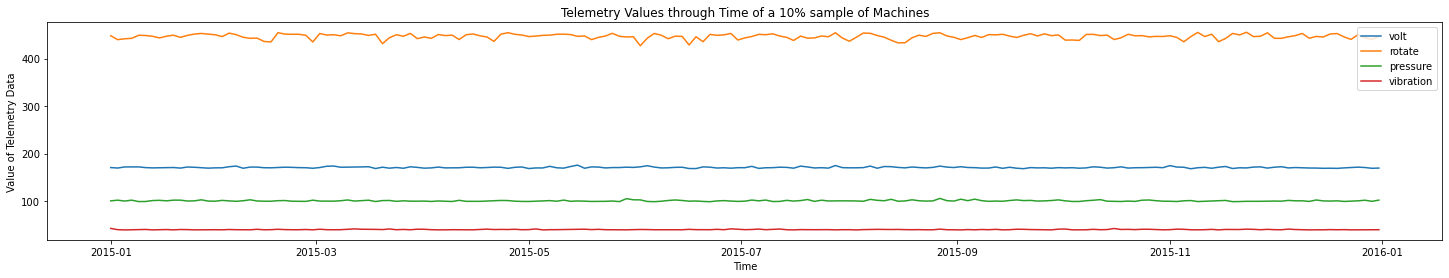

In [9]:
machine_list = machines.sample(frac=0.1)['machineID'].tolist()
# Obtenemos los valores promedio de telemetría de solo el 10% del total de máquinas a través del tiempo en una frecuencia de 2 días ya que hay mucho ruido entre valores
segment_telemetry = telemetry[telemetry.apply(lambda x: x['machineID'] in machine_list, axis=1)]
segment_telemetry.drop('machineID', inplace=True, axis=1)
segmented_data = segment_telemetry.groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plotMachineRecords(segmented_data)
plt.legend(telemetry_features, loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Value of Telemetry Data')
plt.title('Telemetry Values through Time of a 10% sample of Machines')

Va bien, podemos notar más picos y curvas de la telemetria, pero a pesar de ello, esto no dice mucho, 
¿Verdad? Ahora veamos en el **panorama general** como se ve si **añadimos los errores y los failures** para ver que significan los picos de los valores.

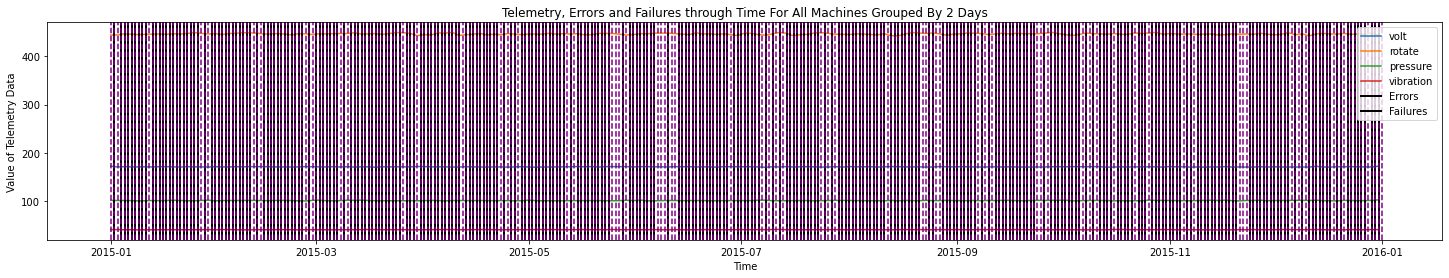

In [10]:
plotMachineRecords(telemetry_values_total)
plotErrorsAndFailures()

 Sin embargo, vemos que practicamente **hay un error o failure casi cada dia o más de una vez por día**, asi que, ¿Qué tal sobre las **10 maquinas**?

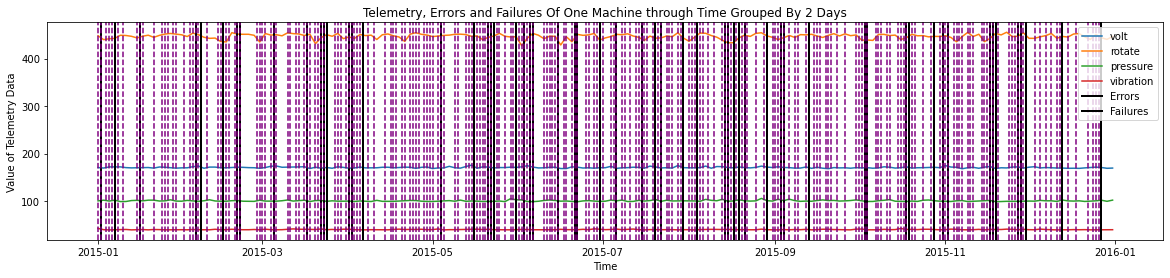

In [11]:
plotMachineRecordsForSegments(machine_list, segmented_data)

Siguen siendo un monton, ¿Verdad? Entonces que tal solo de 2 máquinas al azar

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


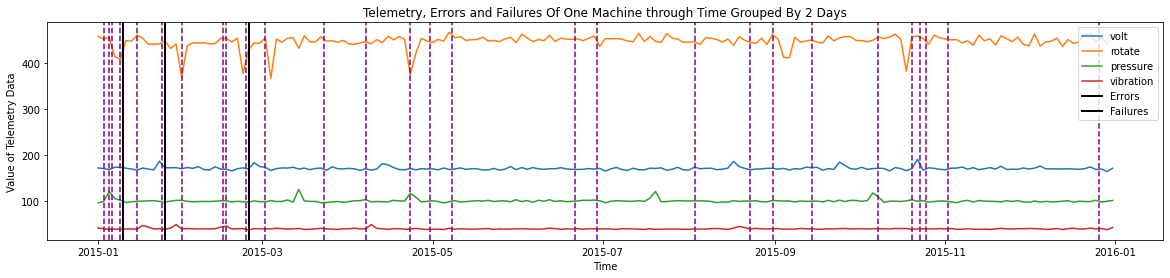

In [12]:
machine_list2 = machines.sample(frac=0.01)['machineID'].tolist()
# Obtenemos los valores promedio de telemetría de solo el 10% del total de máquinas a través del tiempo en una frecuencia de 2 días ya que hay mucho ruido entre valores
segment_telemetry2 = telemetry[telemetry.apply(lambda x: x['machineID'] in machine_list2, axis=1)]
segment_telemetry2.drop('machineID', inplace=True, axis=1)
segmented_data2 = segment_telemetry2.groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()

plotMachineRecordsForSegments(machine_list2, segmented_data2)

¡Ahora podemos apreciarlo! A simple vista podemos ver que **siempre hay un pico en algún valor de telemetria cercano a una falla, pero no son picos muy prominentes para los errores**.

### Relacion entre Mantenimientos, Errores y Fallos

Asi mismo, queremos ver si existe una relación a simple vista entre la cantidad de mantenimientos realizados, los errores que suceden y los fallos que pasan a travez del año 2015.
Preparando datos para realizar gráficas, un par de **get_dummies para dar valores númericos a las columnas** que tienen palabras, ya que son o tipos de errores o de componentes, posteriormente se lo almacena en una sola variable.

In [13]:
bad_machines_week = pd.DataFrame({})
bad_machines = pd.DataFrame({})

failure_comp = ['failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']
errors_errorID = ['errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5']
maint_comp = ['comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']

bad_machines[failure_comp] = pd.get_dummies(failures).groupby('datetime').sum().groupby(pd.Grouper(freq="1W")).sum()[failure_comp]
bad_machines[errors_errorID] = pd.get_dummies(errors).groupby('datetime').sum().groupby(pd.Grouper(freq="1W")).sum()[errors_errorID]
bad_machines[maint_comp] = pd.get_dummies(maint).groupby('datetime').sum().groupby(pd.Grouper(freq="1W")).sum()[maint_comp]
bad_machines[telemetry_features] = pd.get_dummies(telemetry).groupby('datetime').mean().groupby(pd.Grouper(freq="1W")).mean()[telemetry_features]

failures_week = failures.groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()
errors_week = errors.groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()
maint_week = maint[maint['datetime'] >= pd.to_datetime('2015-01-01')].groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()

bad_machines_week['failures'] = failures_week['machineID']
bad_machines_week['errors'] = errors_week['machineID']
bad_machines_week['maints'] = maint_week['machineID']
bad_machines.head()

,failure_comp1,failure_comp2,failure_comp3,failure_comp4,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,comp_comp1,comp_comp2,comp_comp3,comp_comp4,volt,rotate,pressure,vibration
datetime,,,,,,,,,,,,,,,,,
2015-01-04,11,4,5,4,15,13,13,4,5,9,6,5,5,171.284234,444.393003,101.144424,40.620007
2015-01-11,3,10,0,4,24,14,19,12,6,7,12,4,6,170.807218,446.026305,100.634642,40.208003
2015-01-18,3,4,4,3,17,16,20,19,8,7,6,12,8,170.948781,446.073281,100.792854,40.400402
2015-01-25,3,9,4,7,25,19,14,20,9,13,15,15,19,170.799506,447.554132,100.958589,40.339096
2015-02-01,6,4,4,4,25,19,12,16,5,12,17,15,13,170.738547,447.337968,100.939631,40.299914


Como vimos en la primera gráfica de los datos de telemetria, ¡Son demasiados! Asi que esta vez, reduciremos el ruido **agrupandolos por semana** y sin sorpresas, los mantenimientos, errores y fallos resultan tener una relación.

Text(0.5, 1.0, 'Counter of errors, maintenances and failures of machines grouped by one week')

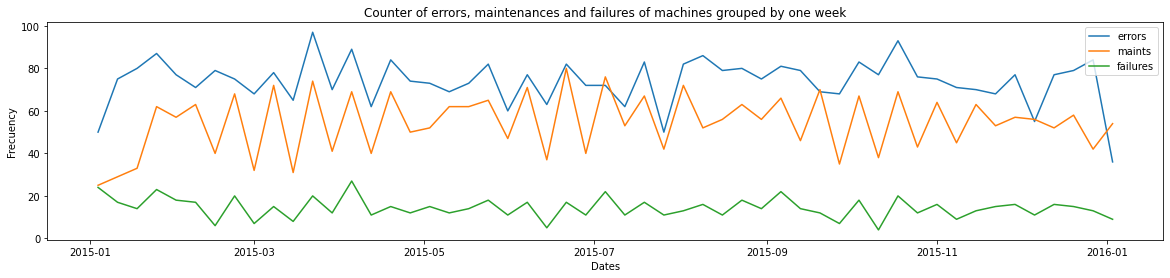

In [14]:
plt.figure(figsize=(20,4))
plt.plot(errors_week.index, errors_week['machineID'])
plt.plot(maint_week.index, maint_week['machineID'])
plt.plot(failures_week.index, failures_week['machineID'])
plt.legend(['errors', 'maints', 'failures'], loc = 'upper right')
plt.xlabel('Dates')
plt.ylabel('Frecuency')
plt.title('Counter of errors, maintenances and failures of machines grouped by one week')

La siguiente gráfica puede que sea un poco difícil de entender, pero esta es la correlación entre la frecuencia de las fallas, errores y mantenimientos.
Si consideramos que la cantidad de errores totales son 3919, de fallos son 761 y de mantenimientos son 3286, entonces podemos empezar a pensar lo siguiente: 
**¿Cada cuantos errores o cada cuantos fallos se realiza un mantenimiento?** o tal vez **¿Cada cuantos errores termina sucediendo un fallo?** Y ya que no hay números especificos ni certeros que puedan decirnos estos ratios, esta correlación tal vez nos ayude a entenderlo.

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 1.01, 'Correlation between frecuency of failures, errors and maintenances')

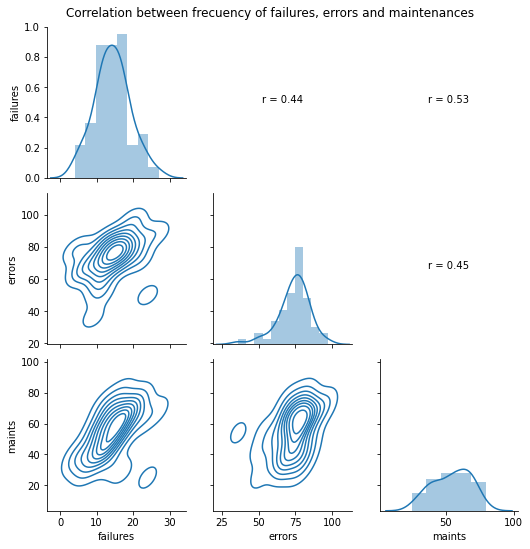

In [15]:
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

#g = sns.pairplot(bad_machines_week, corner=True, kind='kde').fig.suptitle('Correlation between frecuency of failures, errors and maintenances', y=1.01)
g = sns.PairGrid(bad_machines_week)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(reg_coef)
g.fig.suptitle('Correlation between frecuency of failures, errors and maintenances', y=1.01)

La siguiente gráfica trata de explorar un heatmap que busca **correlacionar todas las variables** que tenemos entre si, podemos observar que hay bastante conexión entre los componentes, asi como la falta de relación entre los valores de telemetria con otros con otros valores, pero si notar que el voltaje causa fallos que requieren un cambio en el componente 1 y la vibración provoca fallos que requieren un cambio en el componente 4 a simple vista. Asi como que los fallos estan bastante relacionados a los errores, pero en general requiere mayor investigación.

Text(0.5, 1.0, 'Correlation between frecuency of failures, errors, maintenances and mean telemetry')

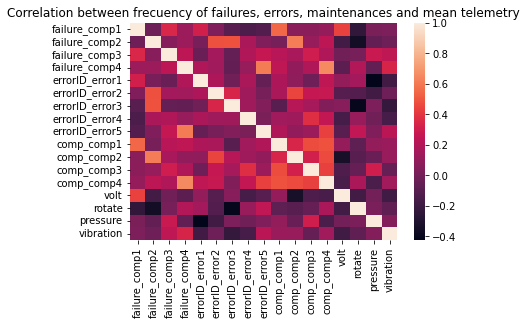

In [16]:
bad_machines_corr = bad_machines.corr(method='pearson')
sns.heatmap(bad_machines_corr, xticklabels=bad_machines.columns, yticklabels=bad_machines.columns)
plt.title('Correlation between frecuency of failures, errors, maintenances and mean telemetry')

A continuación observaremos la **frecuencia con la que se cambian componentes de las máquinas a través del año 2015**:

Text(0.5, 1.0, 'Change of components through time grouped by one week')

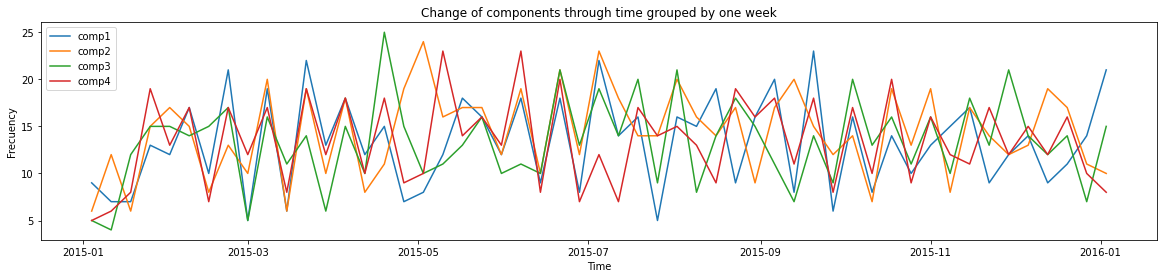

In [17]:
maint_2015 = maint[maint['datetime'] >= pd.to_datetime('2015-01-01')]
maint_2015_comp = maint_2015.groupby(['datetime', 'comp'], as_index=False).count().pivot(index='datetime', columns='comp', values='machineID')
maint_2015_comp = maint_2015_comp.fillna(0)
maint_2015_comp_week = maint_2015_comp.groupby(pd.Grouper(freq="1W")).sum()

plt.figure(figsize=(20,4))
for comp in components.index:
    plt.plot(maint_2015_comp_week.index, maint_2015_comp_week[comp])
plt.legend(maint.groupby('comp').count().index)
plt.xlabel('Time')
plt.ylabel('Frecuency')
plt.title('Change of components through time grouped by one week')

A continuación observaremos la correlación entre los mantenimientos realizados, en el sentido de cada cuantos cambios del compX se cambian del compY, si podemos apreciar algo es que realmente la relación tiende a tener su pico en el area más cercana a 1, por lo que podemos asumir que los componentes se van cambiando constantemente de forma igualitaria, suponiendo de vez en cuando excepciones.

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0.98, 'Correlation between frecuency of component maintenance by week')

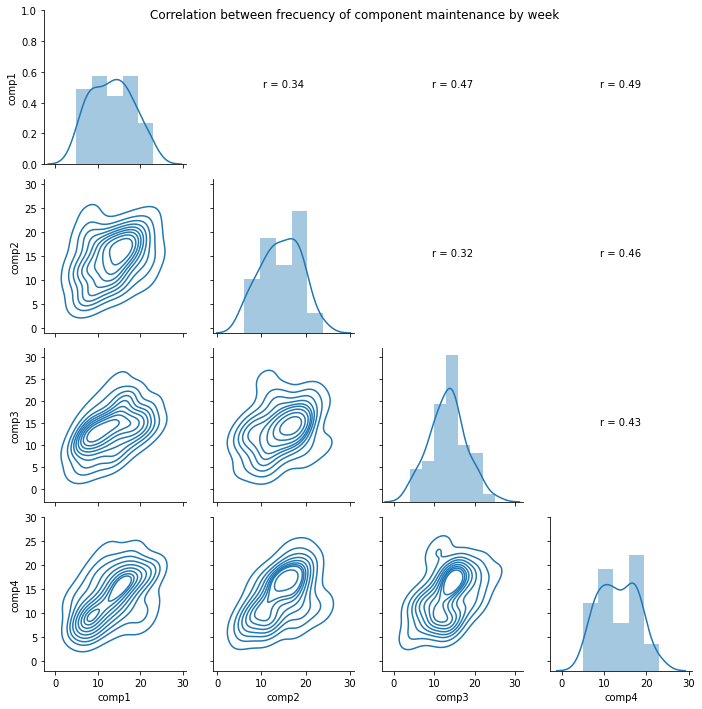

In [18]:
#sns.pairplot(maint_2015_comp, corner=True, kind='kde').fig.suptitle('Correlation between frecuency of component maintenance')

g = sns.PairGrid(maint_2015_comp_week)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(reg_coef)
g.fig.suptitle('Correlation between frecuency of component maintenance by week')

Text(0.5, 1.0, 'Failures of components through time grouped by one week')

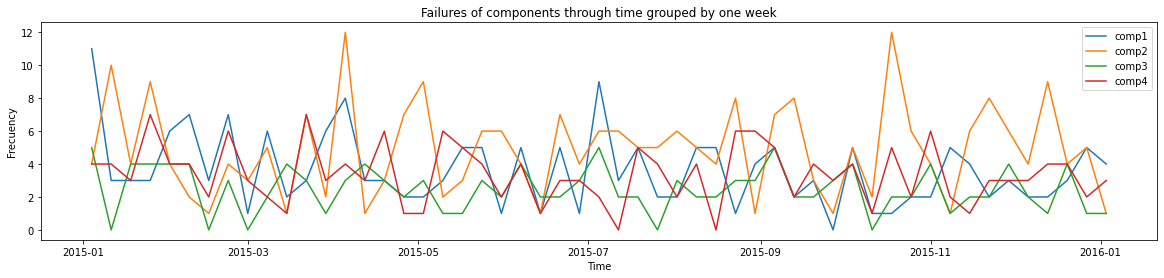

In [19]:
fail_2015_comp = failures.groupby(['datetime', 'failure'], as_index=False).count().pivot(index='datetime', columns='failure', values='machineID')
fail_2015_comp = fail_2015_comp.fillna(0)
fail_2015_comp_week = fail_2015_comp.groupby(pd.Grouper(freq="1W")).sum()

plt.figure(figsize=(20,4))
for comp in components.index:
    plt.plot(fail_2015_comp_week.index, fail_2015_comp_week[comp])
plt.legend(failures.groupby('failure').count().index)
plt.xlabel('Time')
plt.ylabel('Frecuency')
plt.title('Failures of components through time grouped by one week')

A continuación observaremos la correlación entre los mantenimientos realizados, en el sentido de cada cuantos cambios del compX se cambian del compY, si podemos apreciar algo es que realmente la relación tiende a tener su pico en el area más cercana a 1, por lo que podemos asumir que los componentes se van cambiando constantemente de forma igualitaria, suponiendo de vez en cuando excepciones.

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0.98, 'Correlation between frecuency of components failure by week')

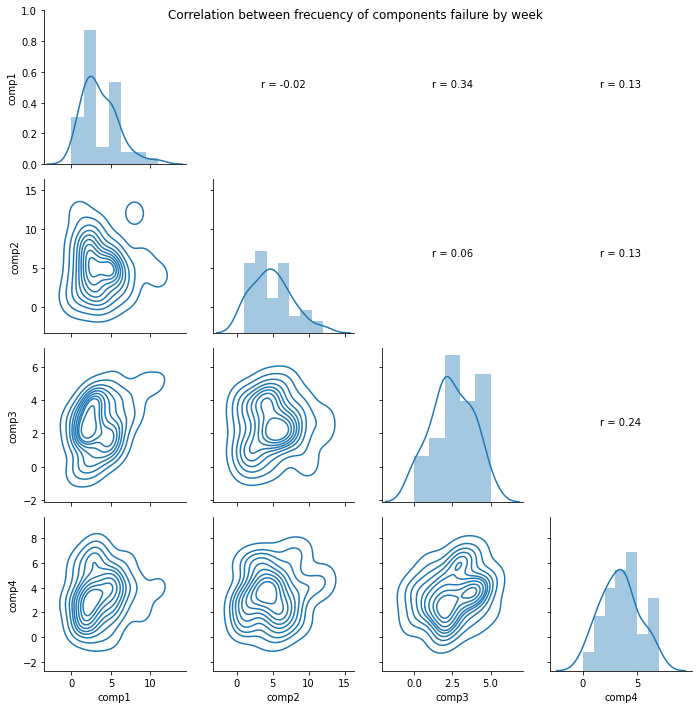

In [20]:
#sns.pairplot(maint_2015_comp, corner=True, kind='kde').fig.suptitle('Correlation between frecuency of component maintenance')

g = sns.PairGrid(fail_2015_comp_week)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(reg_coef)
g.fig.suptitle('Correlation between frecuency of components failure by week')

Si bien podemos suponer bastante con la gráfica de arriba, que nos diría si usaramos un metodo pearson de correlación, el cual involucra la covarianza y el standard deviation, motivo por el que lo escogimos.
Por lo que podemos ver, en realidad existia una mala interpretación del gráfico anterior, ya que los valores estan cercanos al 0.3 en general, podemos asumir que en realidad **hay poca relación entre los cambios de componentes realizados en los mantenimientos**.

Text(0.5, 1.0, 'Errors through time grouped by one week')

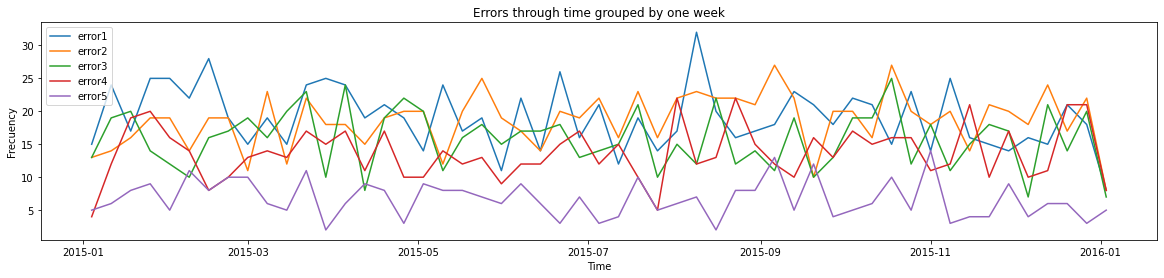

In [21]:
errors_2015_comp = errors.groupby(['datetime', 'errorID'], as_index=False).count().pivot(index='datetime', columns='errorID', values='machineID')
errors_2015_comp = errors_2015_comp.fillna(0)
errors_2015_comp_week = errors_2015_comp.groupby(pd.Grouper(freq="1W")).sum()

plt.figure(figsize=(20,4))
for comp in ['error1', 'error2', 'error3', 'error4', 'error5']:
    plt.plot(errors_2015_comp_week.index, errors_2015_comp_week[comp])
plt.legend(errors.groupby('errorID').count().index)
plt.xlabel('Time')
plt.ylabel('Frecuency')
plt.title('Errors through time grouped by one week')

A continuación observaremos la correlación entre los mantenimientos realizados, en el sentido de cada cuantos cambios del compX se cambian del compY, si podemos apreciar algo es que realmente la relación tiende a tener su pico en el area más cercana a 1, por lo que podemos asumir que los componentes se van cambiando constantemente de forma igualitaria, suponiendo de vez en cuando excepciones.

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0.98, 'Correlation between frecuency of errors by week')

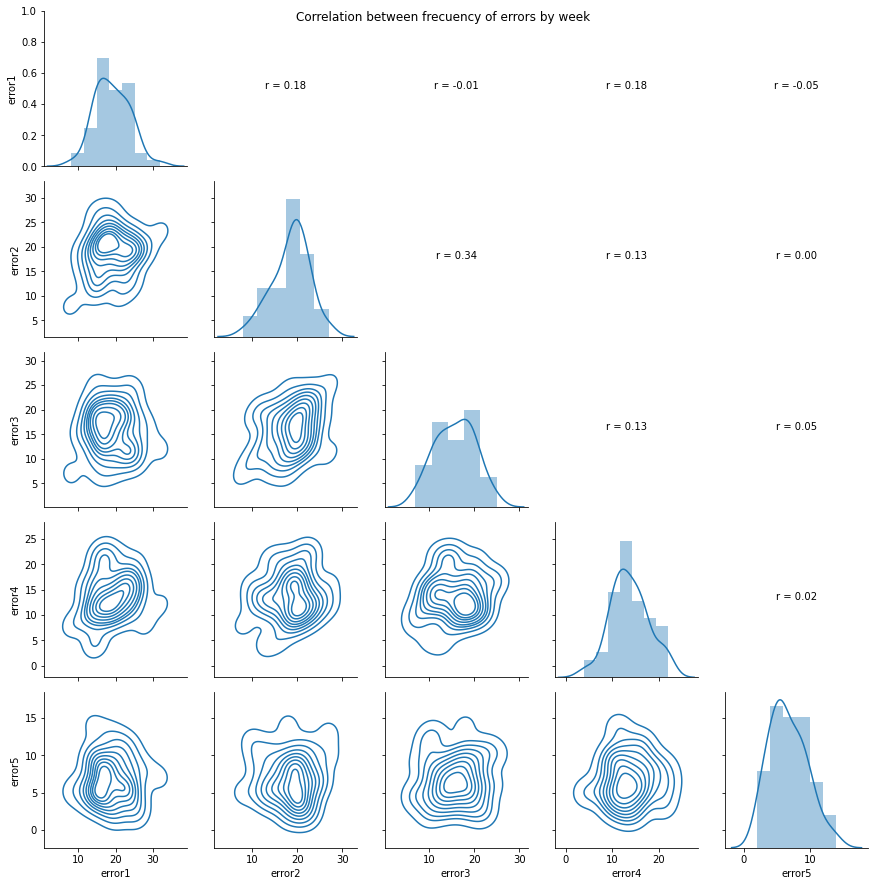

In [22]:
#sns.pairplot(maint_2015_comp, corner=True, kind='kde').fig.suptitle('Correlation between frecuency of component maintenance')

g = sns.PairGrid(errors_2015_comp_week)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(reg_coef)
g.fig.suptitle('Correlation between frecuency of errors by week')

---
## Paso 3: Responder las preguntas planteadas
---
#### ¿Qué modelo de equipamiento son los mas propensos a fallar?

Primero se necesita agrupar la información que concierne la pregunta y plotear el total de fallos por modelos y el promedio de fallas que tienen cada modelos, ya que hay una cantidad total de 100 maquinas, pero sin tener cantidades iguales de cada modelo.

Text(0.5, 1.0, 'Mean failures by model')

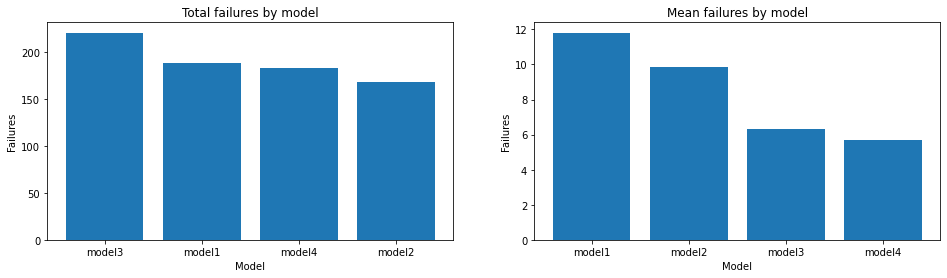

In [23]:
models_failures = machines.copy()
models_failures['failures'] = models_failures.apply(lambda x: len(failures[failures['machineID'] == x['machineID']]), axis=1)
models_failures_total = models_failures.groupby('model').sum()
models_failures_mean = models_failures.groupby('model').mean()

fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].bar(models_failures_total.sort_values('failures', ascending=False).index, models_failures_total.sort_values('failures', ascending=False)['failures'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Failures')
axs[0].set_title('Total failures by model')
axs[1].bar(models_failures_mean.sort_values('failures', ascending=False).index, models_failures_mean.sort_values('failures', ascending=False)['failures'])
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Failures')
axs[1].set_title('Mean failures by model')

##### Respuesta
Podemos observar que en general parecen haber más fallas por parte del modelo 3, pero realmente la diferencia es de apenas +-10 por modelo. Sin embargo, eso es hablando de totales, al inicio observamos que la cantidad de modelos 3 y 4 en servicio son la mayoria, asi que si observamos la cantidad de fallas en promedio podemos notar que los modelos 1 y 2 no son solo poco más de la mitad en cantidad, sino que tienden a tener hasta el doble de fallas, explicando por que  con el tiempo hay menos añadiendose con el tiempo.

#### ¿Cuáles son las causas mas comúnes que provocan los fallos y qué componentes se tienden a reemplazar?

Para responder podríamos simplemente agarrar el heatmap realizado anteriormente y responder "El voltaje" y en segundo lugar "la vibración", sin embargo, son valores o respuestas muy ambiguas para afirmarlo, ya que puede haber mucha más, por tanto necesitaremos observarlo o distinguirlo con **Machine Learning** para saber la respuesta correcta.
Primero **preparamos los datos** e iremos probando con distintos modelos para llegar a una conclusión.

In [24]:
#Selection of train and test data

features = ['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'age', 'model_model1', 'model_model2', 'model_model3', 'model_model4', 'comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4', 'errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5']
failure_labels = ['failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']

machines_train = pd.get_dummies(machines)
machines_train['model'] = machines['model'].apply(getModel)

maint_train = pd.get_dummies(maint)
maint_train = maint_train.groupby(['datetime', 'machineID'], as_index=False).sum()

errors_train = pd.get_dummies(errors)
errors_train = errors_train.groupby(['datetime', 'machineID'], as_index=False).sum()

failures_train = pd.get_dummies(failures)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)

X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
y = telemetry_train[failure_labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=69, shuffle=False)
telemetry_train.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,model_model1,model_model2,model_model3,...,comp_comp4,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,failure_comp1,failure_comp2,failure_comp3,failure_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para poder definir **si el modelo es util o acertado emplearemos mean squared error y r2 score**. Para comparar los resultados emplearemos varios modelos que se especializan en múltiples labels para varios valores de entrada. Entre estos **MultiOutputRegressor con SGDRegressor, Ridge() y DecisionTreeRegressor()**

In [25]:
predict_scores_class = pd.DataFrame(columns=['coverage_error', 'precision_score', 'ranking_loss'])
predict_scores_regg = pd.DataFrame(columns=['r2_score', 'mean_squared_error'])

# Stochastic Gradient Descent Classifier

clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X_train, y_train)
y_pred = clf_sgc.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['SGDClassifier']))

# MLPClassifier

clf_mlp = MultiOutputClassifier(MLPClassifier()).fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['MLPClassifier']))

# RidgeClassifier

clf_r = MultiOutputClassifier(RidgeClassifier()).fit(X_train, y_train)
y_pred = clf_r.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['RidgeClassifier']))

Pero existe un pequeño gran problema con estos modelos y la forma en que trabajan, y eso es que **¡Van muy a lo seguro! o es un error o no, pero no hay aproximación, asi que terminan siendo muy inexactos** a su manera.
Que pasaria **si cambiamos los valores de failures en la información de tal manera que sus valores vayan ascendiendo a medida que se acerca al failure de forma constante**, para poder dar la impresión de que **"se acerca un failure" y asi darle mayor importancia** al valor, un pequeño vistazo a esta forma de pensar sería el siguiente calculo. Asi que se realizará la ascención de 0 a 1 en 24 horas y en 120, para dar una noción de advertencia de 1 día y 5 días previo failure

Text(0.5, 1.0, 'Ranking loss')

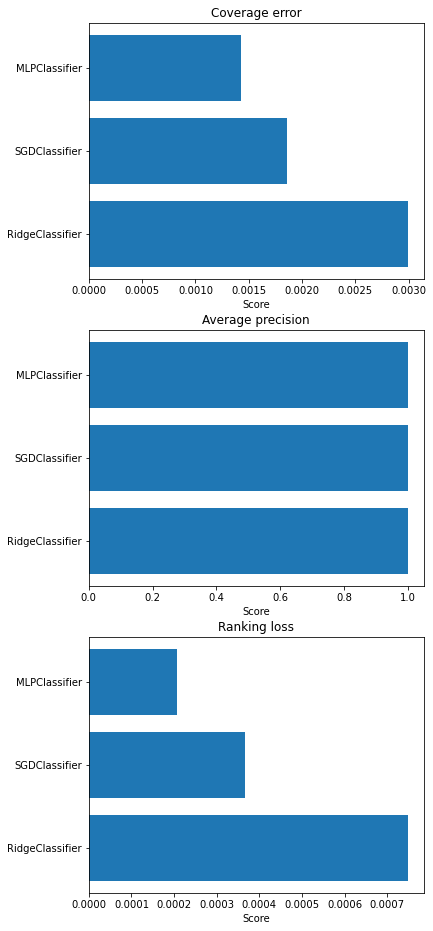

In [26]:
fig, axs = plt.subplots(3, figsize=(6,16))
axs[0].barh(predict_scores_class.sort_values('coverage_error', ascending=False).index, predict_scores_class.sort_values('coverage_error', ascending=False)['coverage_error'])
axs[0].set_xlabel('Score')
axs[0].set_title('Coverage error')
axs[1].barh(predict_scores_class.sort_values('precision_score').index, predict_scores_class.sort_values('precision_score')['precision_score'])
axs[1].set_xlabel('Score')
axs[1].set_title('Average precision')
axs[2].barh(predict_scores_class.sort_values('ranking_loss', ascending=False).index, predict_scores_class.sort_values('ranking_loss', ascending=False)['ranking_loss'])
axs[2].set_xlabel('Score')
axs[2].set_title('Ranking loss')

In [27]:
genFailPrev(pd.get_dummies(failures).iloc[0], 10)

,datetime,machineID,failure_comp1,failure_comp2,failure_comp3,failure_comp4
0,2015-01-04 21:00:00,1,0,0,0,1
1,2015-01-04 22:00:00,1,0,0,0,1
2,2015-01-04 23:00:00,1,0,0,0,1
3,2015-01-05 00:00:00,1,0,0,0,1
4,2015-01-05 01:00:00,1,0,0,0,1
5,2015-01-05 02:00:00,1,0,0,0,1
6,2015-01-05 03:00:00,1,0,0,0,1
7,2015-01-05 04:00:00,1,0,0,0,1
8,2015-01-05 05:00:00,1,0,0,0,1
9,2015-01-05 06:00:00,1,0,0,0,1


In [28]:
genFailPrevScaloned(pd.get_dummies(failures).iloc[0], 10)

,datetime,machineID,failure_comp1,failure_comp2,failure_comp3,failure_comp4
0,2015-01-04 21:00:00,1,0,0,0,0.0
1,2015-01-04 22:00:00,1,0,0,0,0.1
2,2015-01-04 23:00:00,1,0,0,0,0.2
3,2015-01-05 00:00:00,1,0,0,0,0.3
4,2015-01-05 01:00:00,1,0,0,0,0.4
5,2015-01-05 02:00:00,1,0,0,0,0.5
6,2015-01-05 03:00:00,1,0,0,0,0.6
7,2015-01-05 04:00:00,1,0,0,0,0.7
8,2015-01-05 05:00:00,1,0,0,0,0.8
9,2015-01-05 06:00:00,1,0,0,0,0.9


In [29]:
# Aumentar densidad de failures 24

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrev(failures_train.iloc[i], 24), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)


X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = (telemetry_train[failure_labels] > 0) * 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)

In [30]:
# Stochastic Gradient Descent Classifier

clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X_train, y_train)
y_pred = clf_sgc.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['SGDClassifier_24']))

# MLPClassifier

clf_mlp = MultiOutputClassifier(MLPClassifier()).fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['MLPClassifier_24']))

# RidgeClassifier

clf_r = MultiOutputClassifier(RidgeClassifier()).fit(X_train, y_train)
y_pred = clf_r.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['RidgeClassifier_24']))

In [31]:
# Aumentar densidad de failures 72

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrev(failures_train.iloc[i], 24*3), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)

X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = (telemetry_train[failure_labels] > 0) * 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)
y_test = np.array(y_test)

In [32]:
# Stochastic Gradient Descent Classifier

clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X_train, y_train)
y_pred = clf_sgc.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['SGDClassifier_72']))

# MLPClassifier

clf_mlp = MultiOutputClassifier(MLPClassifier()).fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['MLPClassifier_72']))

# RidgeClassifier

clf_r = MultiOutputClassifier(RidgeClassifier()).fit(X_train, y_train)
y_pred = clf_r.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['RidgeClassifier_72']))

In [33]:
# Aumentar densidad de failures 120

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrev(failures_train.iloc[i], 24*5), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)

X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = (telemetry_train[failure_labels] > 0) * 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)
y_test = np.array(y_test)

In [34]:
# Stochastic Gradient Descent Classifier

clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X_train, y_train)
y_pred = clf_sgc.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['SGDClassifier_120']))

# MLPClassifier

clf_mlp = MultiOutputClassifier(MLPClassifier()).fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['MLPClassifier_120']))

# RidgeClassifier

clf_r = MultiOutputClassifier(RidgeClassifier()).fit(X_train, y_train)
y_pred = clf_r.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['RidgeClassifier_120']))

In [35]:
# Aumentar densidad de failures 168

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrev(failures_train.iloc[i], 24*7), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)

X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = (telemetry_train[failure_labels] > 0) * 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)
y_test = np.array(y_test)

In [36]:
# Stochastic Gradient Descent Classifier

clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X_train, y_train)
y_pred = clf_sgc.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['SGDClassifier_168']))

# MLPClassifier

clf_mlp = MultiOutputClassifier(MLPClassifier()).fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['MLPClassifier_168']))

# RidgeClassifier

clf_r = MultiOutputClassifier(RidgeClassifier()).fit(X_train, y_train)
y_pred = clf_r.predict(X_test)

predict_scores_class = predict_scores_class.append(pd.DataFrame({
    'coverage_error': coverage_error(y_test, y_pred),
    'precision_score': label_ranking_average_precision_score(y_test, y_pred),
    'ranking_loss': label_ranking_loss(y_test, y_pred)
}, index=['RidgeClassifier_168']))

Text(0.5, 1.0, 'Ranking loss')

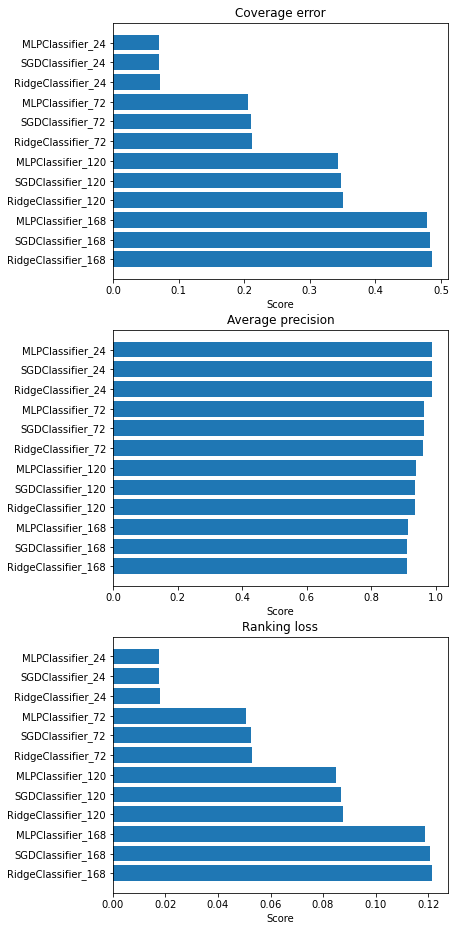

In [37]:
predict_scores_class_2 = predict_scores_class.iloc[3:]
fig, axs = plt.subplots(3, figsize=(6,16))
axs[0].barh(predict_scores_class_2.sort_values('coverage_error', ascending=False).index, predict_scores_class_2.sort_values('coverage_error', ascending=False)['coverage_error'])
axs[0].set_xlabel('Score')
axs[0].set_title('Coverage error')
axs[1].barh(predict_scores_class_2.sort_values('precision_score').index, predict_scores_class_2.sort_values('precision_score')['precision_score'])
axs[1].set_xlabel('Score')
axs[1].set_title('Average precision')
axs[2].barh(predict_scores_class_2.sort_values('ranking_loss', ascending=False).index, predict_scores_class_2.sort_values('ranking_loss', ascending=False)['ranking_loss'])
axs[2].set_xlabel('Score')
axs[2].set_title('Ranking loss')

In [38]:
# Aumentar densidad de failures 24 Scaloned

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrevScaloned(failures_train.iloc[i], 24), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)


X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = telemetry_train[failure_labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)

In [39]:
# Stochastic Gradient Descent Regression

reg_sgc = MultiOutputRegressor(SGDRegressor()).fit(X_train, y_train)
y_pred = reg_sgc.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['SGDRegressor_24_scaloned']))

# Ridge

reg_r = MultiOutputRegressor(Ridge()).fit(X_train, y_train)
y_pred = reg_r.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['Ridge_24_scaloned']))

# DecisionTreeRegressor

reg_dtr = MultiOutputRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
y_pred = reg_dtr.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['DecisionTreeRegressor_24_scaloned']))

In [40]:
# Aumentar densidad de failures 72

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrevScaloned(failures_train.iloc[i], 24*3), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)


X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = telemetry_train[failure_labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)

In [41]:
# Stochastic Gradient Descent Regression

reg_sgc = MultiOutputRegressor(SGDRegressor()).fit(X_train, y_train)
y_pred = reg_sgc.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['SGDRegressor_72_scaloned']))

# Ridge

reg_r = MultiOutputRegressor(Ridge()).fit(X_train, y_train)
y_pred = reg_r.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['Ridge_72_scaloned']))

# DecisionTreeRegressor

reg_dtr = MultiOutputRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
y_pred = reg_dtr.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['DecisionTreeRegressor_72_scaloned']))

In [42]:
# Aumentar densidad de failures 120

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrevScaloned(failures_train.iloc[i], 24*5), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)


X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = telemetry_train[failure_labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)

In [43]:
# Stochastic Gradient Descent Regression

reg_sgc = MultiOutputRegressor(SGDRegressor()).fit(X_train, y_train)
y_pred = reg_sgc.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['SGDRegressor_120_scaloned']))

# Ridge

reg_r = MultiOutputRegressor(Ridge()).fit(X_train, y_train)
y_pred = reg_r.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['Ridge_120_scaloned']))

# DecisionTreeRegressor

reg_dtr = MultiOutputRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
y_pred = reg_dtr.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['DecisionTreeRegressor_120_scaloned']))

In [44]:
# Aumentar densidad de failures 168

failures_train = pd.get_dummies(failures)
##PENSAR COMO OPTIMIZAR??
for i in range(len(failures_train)):
    failures_train = failures_train.append(genFailPrevScaloned(failures_train.iloc[i], 24*7), ignore_index=True)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

telemetry_train = telemetry.merge(machines_train, how='left', left_on='machineID', right_on='machineID')
telemetry_train = telemetry_train.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)


X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = telemetry_train[failure_labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=69, shuffle=False)

In [45]:
# Stochastic Gradient Descent Regression

reg_sgc = MultiOutputRegressor(SGDRegressor()).fit(X_train, y_train)
y_pred = reg_sgc.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['SGDRegressor_168_scaloned']))

# Ridge

reg_r = MultiOutputRegressor(Ridge()).fit(X_train, y_train)
y_pred = reg_r.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['Ridge_168_scaloned']))

# DecisionTreeRegressor

reg_dtr = MultiOutputRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
y_pred = reg_dtr.predict(X_test)

predict_scores_regg = predict_scores_regg.append(pd.DataFrame({
    'r2_score': r2_score(y_test, y_pred),
    'mean_squared_error': mean_squared_error(y_test, y_pred)
}, index=['DecisionTreeRegressor_168_scaloned']))

Finalmente, una vez entrenados los modelos, podemos **comparar los resultados y observar cual es el modelo que mejor responde**. **Según r2 score, DecisionTreeRegressor** es el mejor, pero es el segundo peor según mean squared error. **Según mean squared error, el mejor es DecisionTreeRegressor_stretch_120**, pero es el que peor r2 score posee. **Por eliminación, estamos entre Ridge_stretch_24 y Ridge_stretch_120**, ya que son los que menor error tienen y su r2 score es positivo, **sin embargo, se seleccionara el Ridge_stretch_120, ya que es el que mayor r2 score posee y su diferencia en mean square error es casi ignorable**.

Text(0.5, 1.0, 'mean_squared_error')

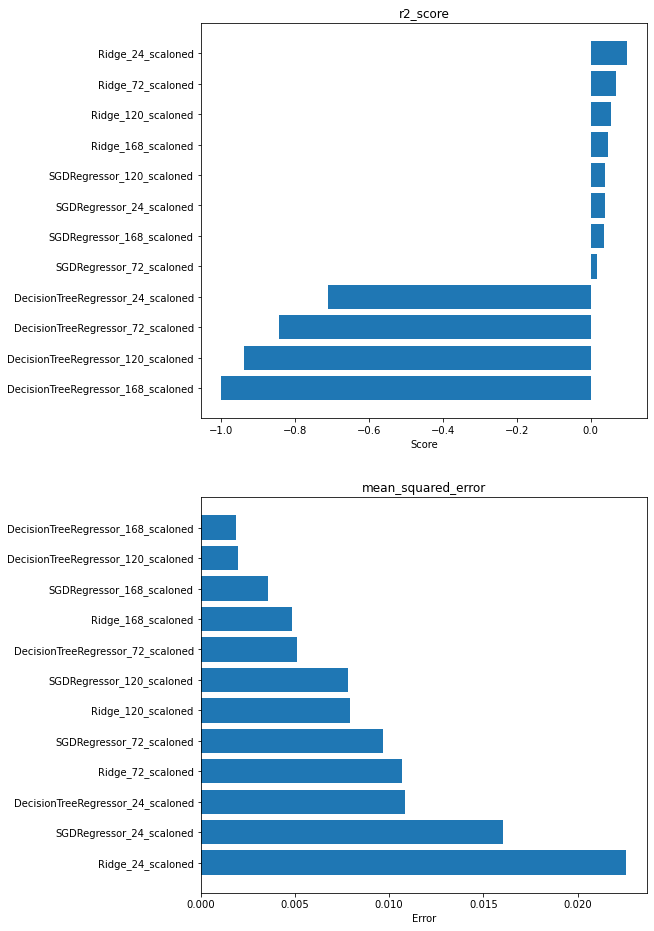

In [46]:
fig, axs = plt.subplots(2,1, figsize=(8,16))
axs[0].barh(predict_scores_regg.sort_values('r2_score').index, predict_scores_regg.sort_values('r2_score')['r2_score'])
axs[0].set_xlabel('Score')
axs[0].set_title('r2_score')
axs[1].barh(predict_scores_regg.sort_values('mean_squared_error').index, predict_scores_regg.sort_values('mean_squared_error', ascending=False)['mean_squared_error'])
axs[1].set_xlabel('Error')
axs[1].set_title('mean_squared_error')

Finalmente observaremos todos los componentes que han sido parte del dataset, telemetria, componentes, errores y modelos y facilmente podremos apreciar cuales han sido los más relevantes.

In [47]:
y_pred

array([[0.        , 0.        , 0.        , 0.        ],
       [0.375     , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.96428571, 0.        , 0.        , 0.        ]])

Text(0.5, 1.0, 'Relevance of coefficients for failure of component 1')

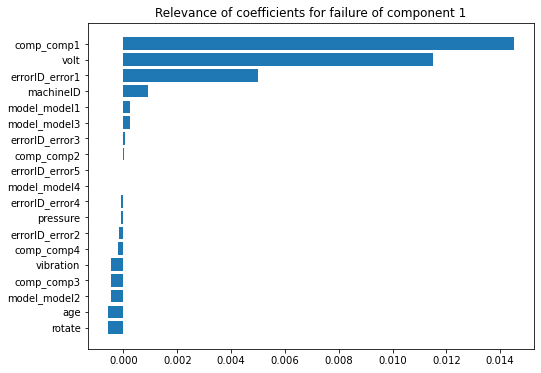

In [48]:
tmp = []
for name, value in zip(features, reg_r.estimators_[0].coef_):
    tmp.append({'name': name, 'value': value})

features_coef = pd.DataFrame(tmp).sort_values('value')
plt.figure(figsize=(8,6))
plt.barh(features_coef['name'], features_coef['value'])
plt.title('Relevance of coefficients for failure of component 1')

Text(0.5, 1.0, 'Relevance of coefficients for failure of component 2')

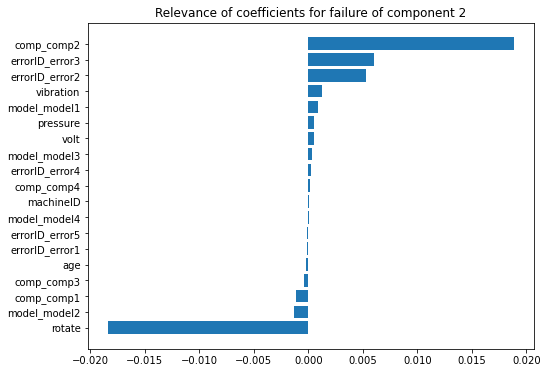

In [49]:
tmp = []
for name, value in zip(features, reg_r.estimators_[1].coef_):
    tmp.append({'name': name, 'value': value})

features_coef = pd.DataFrame(tmp).sort_values('value')
plt.figure(figsize=(8,6))
plt.barh(features_coef['name'], features_coef['value'])
plt.title('Relevance of coefficients for failure of component 2')

Text(0.5, 1.0, 'Relevance of coefficients for failure of component 3')

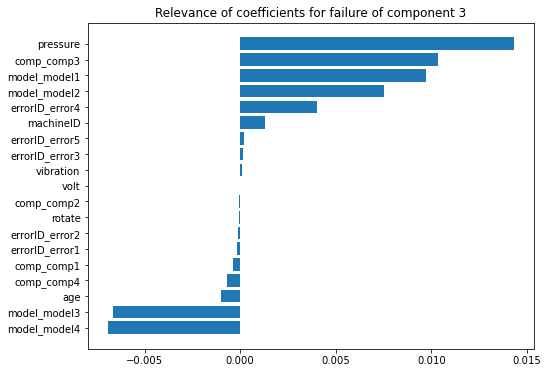

In [50]:
tmp = []
for name, value in zip(features, reg_r.estimators_[2].coef_):
    tmp.append({'name': name, 'value': value})

features_coef = pd.DataFrame(tmp).sort_values('value')
plt.figure(figsize=(8,6))
plt.barh(features_coef['name'], features_coef['value'])
plt.title('Relevance of coefficients for failure of component 3')

Text(0.5, 1.0, 'Relevance of coefficients for failure of component 4')

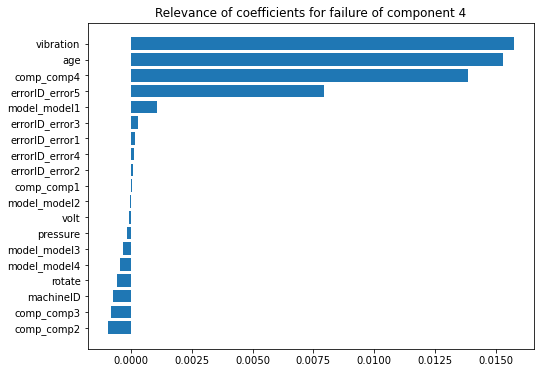

In [51]:
tmp = []
for name, value in zip(features, reg_r.estimators_[3].coef_):
    tmp.append({'name': name, 'value': value})

features_coef = pd.DataFrame(tmp).sort_values('value')
plt.figure(figsize=(8,6))
plt.barh(features_coef['name'], features_coef['value'])
plt.title('Relevance of coefficients for failure of component 4')

Text(0.5, 1.0, 'Replacements by component')

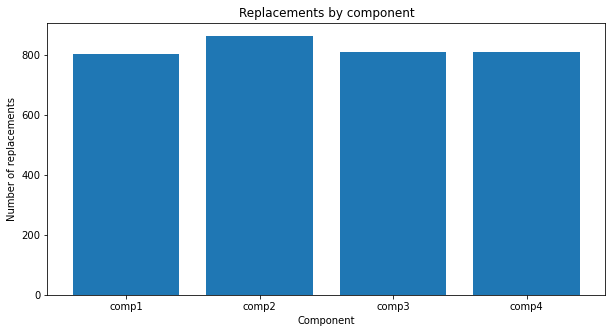

In [52]:
plt.figure(figsize=(10,5))
plt.bar(maint.groupby('comp').count().index, maint.groupby('comp').count()['machineID'])
plt.xlabel('Component')
plt.ylabel('Number of replacements')
plt.title('Replacements by component')

#### Respuesta
Las causas mas comunes tienden a ser el voltaje, el error1 y el modelo 1 y las que menos relevancia tuvieron son la edad del modelo sorprendentemente y el valor de rotación que se pudo ver a simple vista que era irrelevante.
Además los componentes que más se cambian son Comp1, Comp2, Comp4, Comp3, ordenado desde el que más se cambia al que menos se cambia.


#### ¿Existe relación entre las fechas de los fallos con algun evento en especifico? Por ejemplo un apagon masivo, en cuyo caso, ¿Qué información podría proveer?

Text(0.5, 1.0, 'Counter of data of machines')

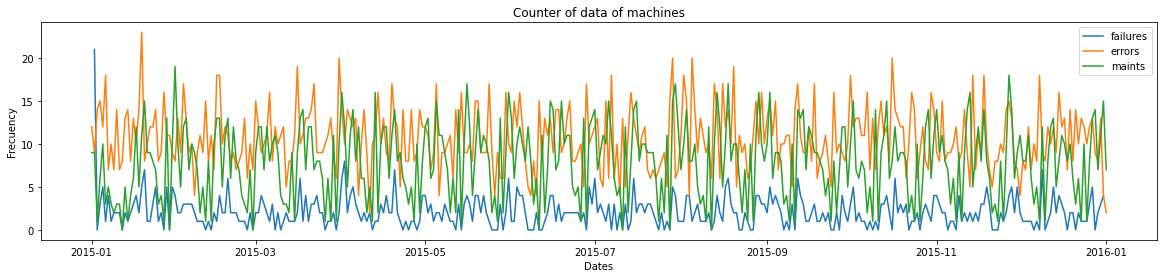

In [53]:
failures_week = failures.groupby('datetime').count().groupby(pd.Grouper(freq="1D")).sum()
errors_week = errors.groupby('datetime').count().groupby(pd.Grouper(freq="1D")).sum()
maint_week = maint[maint['datetime'] >= pd.to_datetime('2015-01-01')].groupby('datetime').count().groupby(pd.Grouper(freq="1D")).sum()

plt.figure(figsize=(20,4))
plt.plot(failures_week.index, failures_week['machineID'])
plt.plot(errors_week.index, errors_week['machineID'])
plt.plot(maint_week.index, maint_week['machineID'])
plt.legend(['failures', 'errors', 'maints'], loc = 'upper right')
plt.xlabel('Dates')
plt.ylabel('Frecuency')
plt.title('Counter of data of machines')

#### Respuesta

(Nos olvidamos poner la respuesta, ya que fue negativa) Lamentablemente **falta información** sobre el data center del que se recopilo información, asi que no se encontro resultados sobre ello.

#### ¿Tendrá relación la cantidad de años en servicio y el promedio de fallos en dicho tiempo? Sera posible que a medida que más envejezca, más propenso sea a tener errores o seguira igual.

Text(0.5, 1.0, 'Failures by time of service')

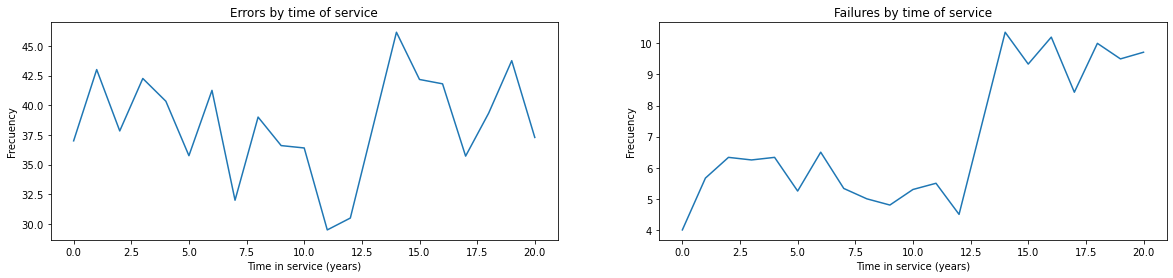

In [54]:
machines_exhaustion = machines.copy()
machines_exhaustion['errors'] = machines.apply(lambda x: len(errors[errors['machineID'] == x['machineID']]), axis=1)
machines_exhaustion['failures'] = machines.apply(lambda x: len(failures[failures['machineID'] == x['machineID']]), axis=1)
machines_exhaustion_age = machines_exhaustion.groupby('age').mean()

fig, axs = plt.subplots(1, 2, figsize=(20,4))
axs[0].plot(machines_exhaustion_age.index, machines_exhaustion_age['errors'])
axs[0].set_xlabel('Time in service (years)')
axs[0].set_ylabel('Frecuency')
axs[0].set_title('Errors by time of service')
axs[1].plot(machines_exhaustion_age.index, machines_exhaustion_age['failures'])
axs[1].set_xlabel('Time in service (years)')
axs[1].set_ylabel('Frecuency')
axs[1].set_title('Failures by time of service')

##### Respuesta

A través del tiempo se observan picos en subida y picos en bajada, estos pueden tener relación con los cambios de componentes, sin embargo falta más información para poder realizar semejante declaración, sin embargo, lo que si podemos observar a simple vista, es que a partir de aproximadamente los 12 años de servicio las máquinas empiezan a tener a escalar hasta el doble de la cantidad de fallos que tienen en promedio en fechas anteriores. Esto se ve reflejado en la frecuencia de los errores, sin embargo estos se mantienen en menor proporción que las fallas.

#### ¿Qué relacion existe entre las variables de telemetria? ¿Podemos encontrar relaciones entre las fallas y las variables de telemetria?

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bramo\.conda\envs\data_science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0.98, 'Correlation of telemetry values')

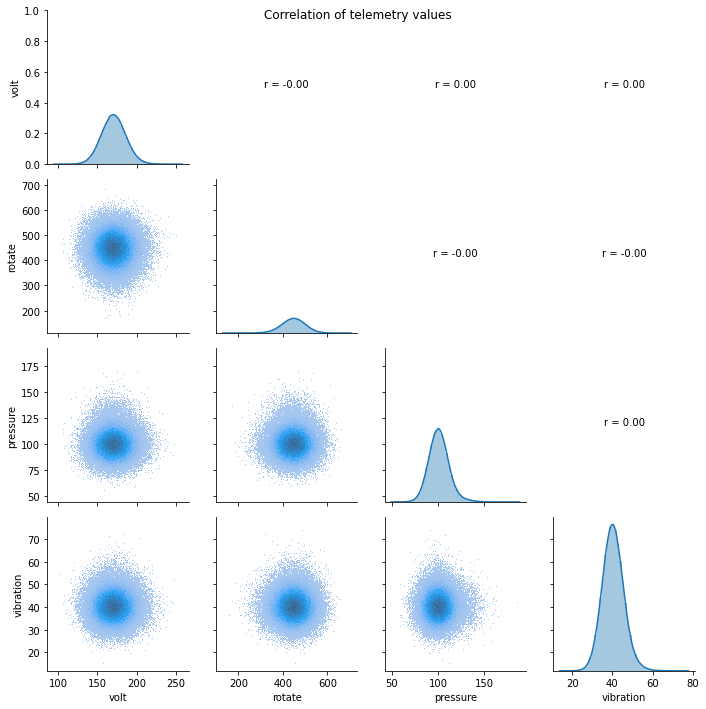

In [55]:
#sns.pairplot(telemetry[telemetry_features], corner=True, kind='hist').fig.suptitle('Correlation of telemetry values')
##LO MISMO CON FALLOS Y ERRORES
g = sns.PairGrid(telemetry[telemetry_features])
g.map_diag(sns.distplot)
g.map_lower(sns.histplot)
g.map_upper(reg_coef)
g.fig.suptitle('Correlation of telemetry values')

Podemos observar que al estar las correlaciones tan proximas a 0 una vez estandarizadas, asumimos que realmente no tienen casi ninguna relación entre si.

#### ¿Se puede clasificar el modelo de las máquinas a partir de los datos de telemetria, errores y fallos?

En realidad, esta respuesta se podía observar en el heatmap de relaciones, sin embargo, al ser variables tan... impredecibles por la cantidad de valores en el dataset comparando la cantidad de datos de telemetria con la cantidad de errores, fallos y mantenimientos, que pudo haber tenido otro resultado.

Para intentar responder esta pregunta se emplearan los clasificadores **SGDClassifier, MLPClassifier y RidgeClassifier**, que se consideran los adecuados para el dataset que poseemos.

In [56]:
#Selection of train and test data in classification


all_features = telemetry_features + ['errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5', 'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']
labels = ['model']
# DecisionTreeClassifier() LinearSVC() KNeighborsClassifier() GaussianProcessClassifier()
classifiers_scores = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'])
classifiers = [SGDClassifier(), MLPClassifier(), RidgeClassifier()]


In [57]:
X = telemetry_train[telemetry_features]
X = StandardScaler().fit_transform(X)
y = telemetry_train['model']
classifiers_scores = getClassifierScoresType(classifiers_scores, 'telemetry', X, y)


In [58]:
X = telemetry_train[all_features]
X = StandardScaler().fit_transform(X)
classifiers_scores = getClassifierScoresType(classifiers_scores, 'all_features', X, y)
classifiers_scores

,accuracy,precision,recall,f1
SGDClassifier_telemetry,0.281617,0.276950,0.281617,0.265988
MLPClassifier_telemetry,0.349914,0.275338,0.349914,0.182024
RidgeClassifier_telemetry,0.349994,0.122496,0.349994,0.181476
SGDClassifier_all_features,0.318189,0.292363,0.318189,0.293384
MLPClassifier_all_features,0.360655,0.397129,0.360655,0.208158
RidgeClassifier_all_features,0.358481,0.313049,0.358481,0.199701


In [59]:
# To get the best n_components for PCA

#for n_components in np.linspace(0.85, 0.99, num=5, endpoint=False):
#    X = telemetry_train[all_features]
#    X = StandardScaler().fit_transform(X)
#    X = PCA(n_components=n_components).fit_transform(X)
#    classifiers_scores = getClassifierScoresType(classifiers_scores, ('all_featuresPCA' + str(n_components)), X, y)

In [60]:
X = telemetry_train[all_features]
X = StandardScaler().fit_transform(X)
X = PCA(n_components=0.962).fit_transform(X)
classifiers_scores = getClassifierScoresType(classifiers_scores, ('all_features_PCA'), X, y)

Text(0.5, 1.0, 'f1')

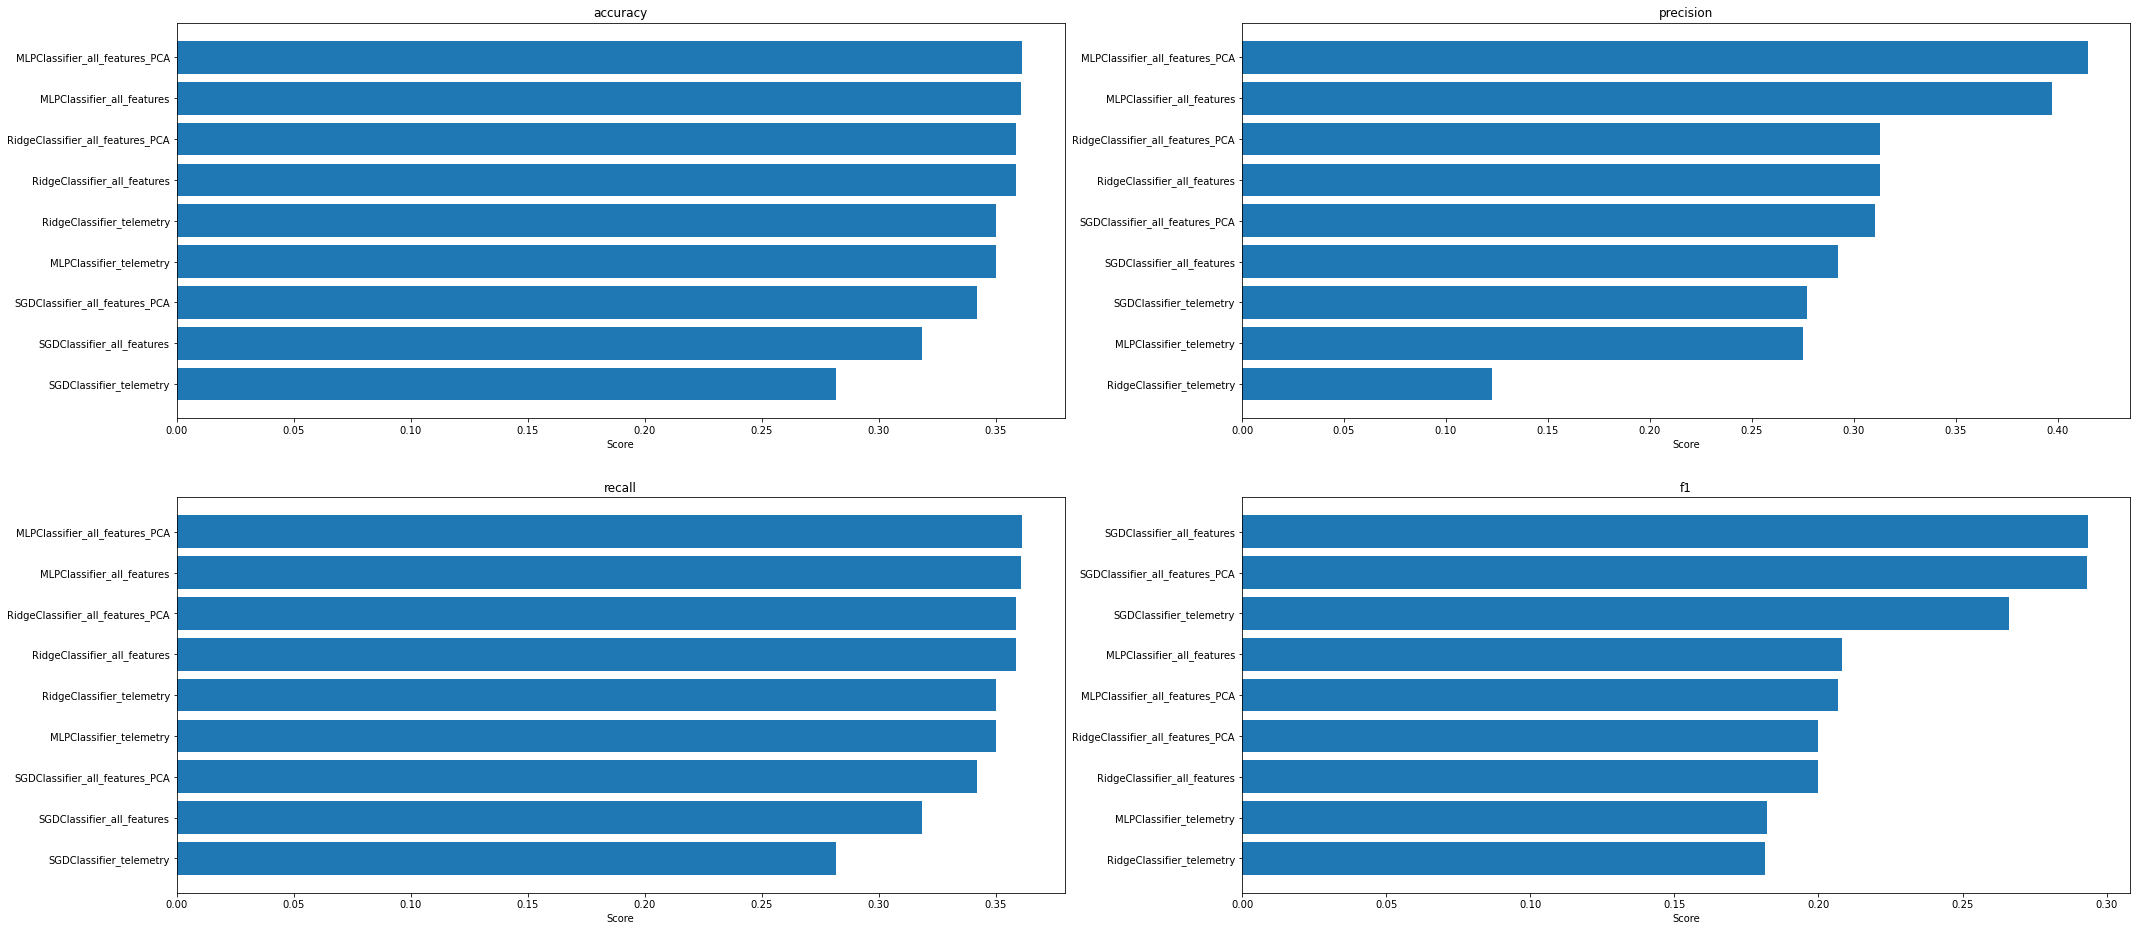

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(35,16))
axs[0,0].barh(classifiers_scores.sort_values('accuracy').index, classifiers_scores.sort_values('accuracy')['accuracy'])
axs[0,0].set_xlabel('Score')
axs[0,0].set_title('accuracy')
axs[0,1].barh(classifiers_scores.sort_values('precision').index, classifiers_scores.sort_values('precision')['precision'])
axs[0,1].set_xlabel('Score')
axs[0,1].set_title('precision')
axs[1,0].barh(classifiers_scores.sort_values('recall').index, classifiers_scores.sort_values('recall')['recall'])
axs[1,0].set_xlabel('Score')
axs[1,0].set_title('recall')
axs[1,1].barh(classifiers_scores.sort_values('f1').index, classifiers_scores.sort_values('f1')['f1'])
axs[1,1].set_xlabel('Score')
axs[1,1].set_title('f1')

#### Respuesta

Realmente no se pudo hallar ningún patron o relación prometedora después de realizar la clasificación con distintos modelos, por lo que se puede decir que el resultado es que no hay relaciones satisfactorias entre cada valor de telemetria y otros con una o dos excepciones.